In [592]:
import duckdb
conn = duckdb.connect('cnpj.db')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

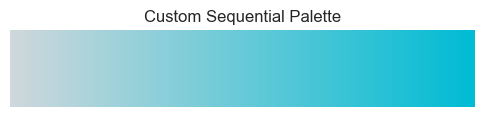

In [593]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_sequential_palette(color1, color2, n=256):
    """Create a sequential color palette."""
    cmap_segment = LinearSegmentedColormap.from_list("custom_sequential", [color1, color2], N=n)
    return cmap_segment

color1 = '#CFD8DC'
color2 = '#00BCD4'

# Create the custom sequential palette
custom_palette = create_sequential_palette(color1, color2)

# Display the palette
plt.figure(figsize=(6, 1))
plt.imshow(np.linspace(0, 100, 256)[None, :], aspect='auto', cmap=custom_palette)
plt.axis('off')
plt.title('Custom Sequential Palette')
plt.show()


In [625]:
tables = conn.execute("SHOW TABLES").fetchall()
tables = [t[0] for t in tables]
tables = [t for t in tables if not t.endswith("_raw")]
print(tables)

['active_companies', 'cnae', 'empresas', 'estabelecimentos', 'natureza', 'simple', 'socios']


In [595]:
for table in tables:
    count = conn.execute(f"SELECT COUNT(*) FROM {table}").df().iloc[0,0]
    print(f"{table}: {count}")

cnae: 1358
empresas: 56554307
estabelecimentos: 59495407
natureza: 89
simple: 38371644
socios: 23765603


# Question 1
## How many companies there registed in brazil until last year?

In [596]:
companies_bys_year = conn.execute("""SELECT left(activity_start_date, 4) AS year
                                  , COUNT(*) AS new_companies
                                  , SUM(COUNT(*)) OVER (ORDER BY year) AS total_companies
                                    FROM ESTABELECIMENTOS
                                    WHERE identifier IN (1)
                                    GROUP BY year
                                    ORDER BY year DESC;""").df()
#remove last year because it is not complete
companies_bys_year = companies_bys_year.iloc[1:]
companies_bys_year.head(5)

,year,new_companies,total_companies
1,2023,3852651,56062893.0
2,2022,3855778,52210242.0
3,2021,4019863,48354464.0
4,2020,3915072,44334601.0
5,2019,3167006,40419529.0


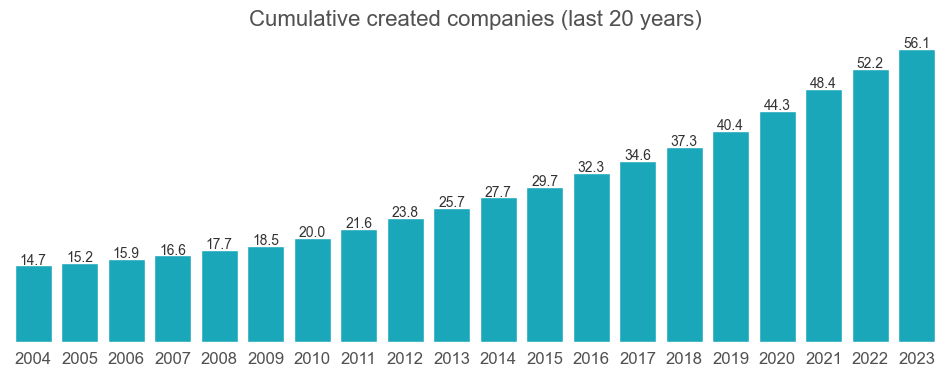

In [597]:
# plotting the time series of cumulative companies created per year
plot_df = companies_bys_year.copy().head(20).sort_values('year', ascending=True).reset_index()

plot_df["total_companies"] = (plot_df["total_companies"] / 1000000).round(1)
# converting year to datetime
plot_df['year'] = pd.to_datetime(plot_df['year']).dt.year

# Plotting the time series of companies created per year
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=plot_df,  y='total_companies',x='year', color=color2)
plt.title("Cumulative created companies (last 20 years)", fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)

for index, row in plot_df.iterrows():
    plt.text(row.name, row.total_companies + 0.2, str(row.total_companies), color='black', ha="center", fontsize=10, alpha=0.8)

# Question 2
## How many each year?

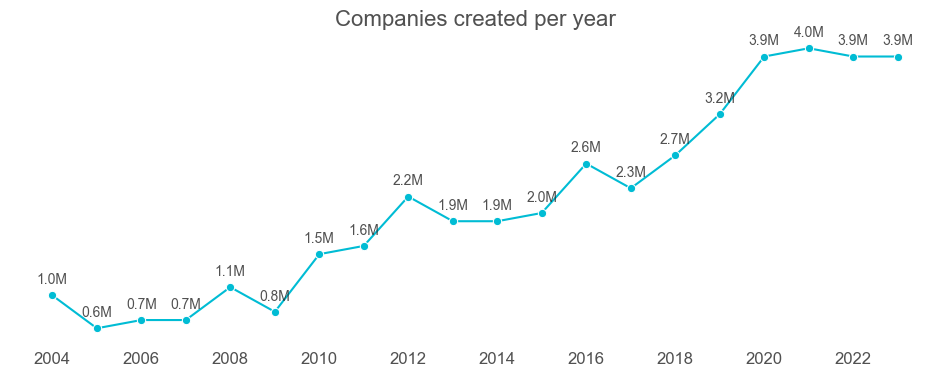

In [598]:
# Plotting time series of companies created per year

plot_df = companies_bys_year.copy().head(20)
plot_df["new_companies"] = (plot_df["new_companies"] / 1000000).round(1)
# converting year to datetime
plot_df['year'] = pd.to_datetime(plot_df['year'])
# Plotting the time series of companies created per year

plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.lineplot(data=plot_df, x='year', y='new_companies', marker='o', color=color2)
plt.title("Companies created per year", fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8);
plt.box(False)

# Adding data labels
for index, row in plot_df.iterrows():
    plt.text(row['year'], row['new_companies'] + 0.1, f'{row["new_companies"]}M', ha = 'center', va = 'bottom', fontsize=10, alpha=0.8)
plt.show()



# Question 3
## How many are still active?

In [599]:
companies_bys_status = conn.execute("""SELECT 
                                        CASE 
                                            WHEN registration_status = 1 THEN 'NULL'
                                            WHEN registration_status = 2 THEN 'ACTIVE'
                                            WHEN registration_status = 3 THEN 'SUSPENDED'
                                            WHEN registration_status = 4 THEN 'INACTIVE'
                                            WHEN registration_status = 8 THEN 'CLOSED'
                                        END AS status_name,
                                        COUNT(*) AS companies_count,
                                        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (), 1) AS percentage,
                                    FROM 
                                        ESTABELECIMENTOS 
                                    GROUP BY 
                                        ALL
                                    ORDER BY 
                                        companies_count DESC;""").df()
companies_bys_status.head(5)

,status_name,companies_count,percentage
0,CLOSED,26672875,44.8
1,ACTIVE,23536635,39.6
2,INACTIVE,8929908,15.0
3,SUSPENDED,263517,0.4
4,NULL,92472,0.2


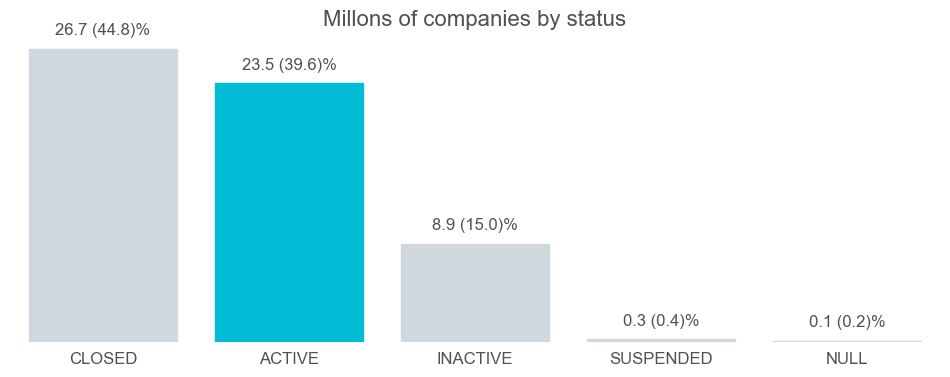

In [600]:
# Plotting the distribution of companies by status adding data labels and removing the grid lines, y-axis labels and canvas border
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=companies_bys_status, x='status_name', y='companies_count', legend=False)

# cooring the bar that represents the active companies and all the other bars in gray
active_index = companies_bys_status[companies_bys_status['status_name'] == 'ACTIVE'].index[0]
for i in range(companies_bys_status.shape[0]):
    if i != active_index:
        plt.gca().get_children()[i].set_color(color1)
    else:
        plt.gca().get_children()[i].set_color(color2)

plt.title('Millons of companies by status', fontsize=16, alpha=0.8)
# Adding the data labels
for i in range(companies_bys_status.shape[0]):
    count = companies_bys_status.iloc[i]['companies_count'] 
    percentage = companies_bys_status.iloc[i]['percentage']
    plt.text(i, count + 10**6, f'{round(count/1000000,1)} ({percentage})%', ha = 'center', va = 'bottom', fontsize=12, alpha=0.8)
#removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)
plt.show()

# Question 4
## Where are those active companies?

In [601]:
active_companies_by_state = conn.execute("""SELECT
                                     state
                                    , COUNT(*) AS companies_count
                                    , ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER ()) AS percentage
                                FROM
                                    ESTABELECIMENTOS
                                WHERE
                                    state <> 'EX' AND identifier = 1 AND registration_status = 2
                                GROUP BY
                                     state
                                HAVING 
                                    companies_count > 1
                                ORDER BY
                                    companies_count DESC
                               ;""").df()
active_companies_by_state.head(5)

,state,companies_count,percentage
0,SP,6758941,30.0
1,MG,2356966,11.0
2,RJ,1901163,9.0
3,PR,1590832,7.0
4,RS,1438637,6.0


/var/folders/5l/rw2smw3x7p1_g2r7qggpzqkh0000gn/T/ipykernel_98850/1003188781.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, percentage, state in zip(brazil.geometry.centroid.x, brazil.geometry.centroid.y, brazil['companies_count'], brazil['percentage'], brazil['state']):


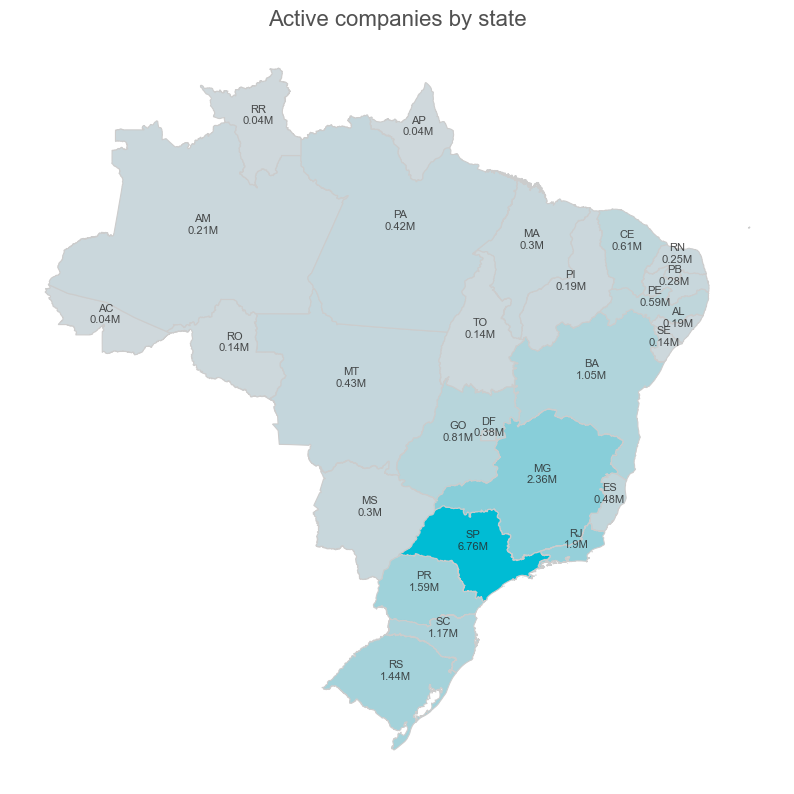

In [602]:
#plotting the distribution of active companies by state in a brazilian map
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# loading the brazilian states shapefile, available at https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson
brazil = gpd.read_file('brazil-states.geojson')
 
# merging the shapefile with the active companies by state
brazil = brazil.merge(active_companies_by_state, left_on='sigla', right_on='state')
brazil['companies_count'] = (brazil['companies_count']/10**6).round(2)

# creating the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plotting the brazilian states
brazil.plot(column='companies_count', cmap=custom_palette, linewidth=0.8, ax=ax, edgecolor='0.8')
# removing the axis
ax.axis('off')
# setting the title
ax.set_title('Active companies by state', fontdict={'fontsize': '16', 'fontweight' : '3'}, alpha=0.8)

# Adding the data labels
for x, y, label, percentage, state in zip(brazil.geometry.centroid.x, brazil.geometry.centroid.y, brazil['companies_count'], brazil['percentage'], brazil['state']):
    ax.text(x, y, f'{state}\n{label}M', ha='center', fontsize=8, alpha=0.8)

# Question 4
# What are the most common activities of the companies in Brazil?

In [806]:
most_common_activities_state = conn.execute("""SELECT
                                       state,
                                        c.description AS activity
                                        , COUNT(*) AS companies_count
                                        , ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (), 5) AS percentage
                                    FROM
                                        estabelecimentos e
                                    INNER JOIN
                                        cnae c ON e.main_activity = c.code
                                    WHERE
                                        e.identifier = 1 AND e.registration_status = 2 AND e.state <> 'EX'
                                    GROUP BY
                                        1,2
                                    ORDER BY
                                        companies_count DESC;""").df()

most_common_activities_state = conn.execute("""SELECT *, 
                                        SUM(percentage) OVER (ORDER BY companies_count DESC) AS cumulative_percentage,
                                      -- rank of the activity per state
                                        RANK() OVER (PARTITION BY state ORDER BY companies_count DESC) AS rank
                                    FROM
                                        most_common_activities_state;                                      
                                      """).df()

most_common_activitiy_per_state = conn.execute("""SELECT CASE WHEN regexp_matches(activity, 'Comércio','i') THEN 'COMMERCE' ELSE 'OTHER' END AS category
                                               , string_agg(state, ', ') AS states, count(*) AS states_count
                                               , FIRST(activity) AS most_common_activity
                                    FROM most_common_activities_state
                                    WHERE rank = 1
                                    GROUP BY category
                                    ORDER BY 3 DESC;""").df()

most_common_activities = conn.execute("""SELECT
                                        c.description AS activity
                                        , COUNT(*) AS companies_count
                                        , ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (), 5) AS percentage
                                    FROM
                                        estabelecimentos e
                                    INNER JOIN
                                        cnae c ON e.main_activity = c.code
                                    WHERE
                                        e.identifier = 1 AND e.registration_status = 2 AND e.state <> 'EX'
                                    GROUP BY
                                        1
                                    ORDER BY
                                        companies_count DESC;""").df()

In [807]:
most_common_activities

,activity,companies_count,percentage
0,Comércio varejista de artigos do vestuário e a...,982480,4.41787
1,"Cabeleireiros, manicure e pedicure",810029,3.64242
2,Promoção de vendas,613499,2.75869
3,Obras de alvenaria,531588,2.39037
4,Preparação de documentos e serviços especializ...,445286,2.00230
...,...,...,...
1328,Elaboração de combustíveis nucleares,1,0.00000
1329,Fabricação de óleo de milho refinado,1,0.00000
1330,Fabricação de veículos militares de combate,1,0.00000
1331,Extração de amianto,1,0.00000


In [808]:
pd.options.display.max_colwidth = 50
most_common_activitiy_per_state

,category,states,states_count,most_common_activity
0,COMMERCE,"AL, RN, SP, ES, PB, AP, RO, AM, CE, SE, MG, TO...",25,Comércio varejista de artigos do vestuário e a...
1,OTHER,"DF, RJ",2,"Cabeleireiros, manicure e pedicure"


In [809]:
most_common_activities

,activity,companies_count,percentage
0,Comércio varejista de artigos do vestuário e a...,982480,4.41787
1,"Cabeleireiros, manicure e pedicure",810029,3.64242
2,Promoção de vendas,613499,2.75869
3,Obras de alvenaria,531588,2.39037
4,Preparação de documentos e serviços especializ...,445286,2.00230
...,...,...,...
1328,Elaboração de combustíveis nucleares,1,0.00000
1329,Fabricação de óleo de milho refinado,1,0.00000
1330,Fabricação de veículos militares de combate,1,0.00000
1331,Extração de amianto,1,0.00000


In [810]:
activites_representative_range = most_common_activities['percentage_range'] = most_common_activities['percentage'].apply(lambda x: '0-0.01%' if x <= 0.01 else '0.01-0.1%' if x <= 0.1 else '0.1-1%' if x <= 1 else '1-10%' if x <= 10 else '10-100%')
# count activities and sum the percentage by percentage range
activites_representative_range = most_common_activities.groupby('percentage_range').agg({'activity': 'count', 'percentage': 'sum'}).reset_index()

# adding the cumulative percentage

activites_representative_range['cumulative_percentage'] = activites_representative_range['percentage'].cumsum().round(1)
activites_representative_range['percentage_activity'] = (activites_representative_range['activity'] / activites_representative_range['activity'].sum() * 100).round(1).sort_values(ascending=False)
activites_representative_range

,percentage_range,activity,percentage,cumulative_percentage,percentage_activity
0,0-0.01%,770,1.89813,1.9,57.8
1,0.01-0.1%,376,13.24833,15.1,28.2
2,0.1-1%,167,49.34131,64.5,12.5
3,1-10%,20,35.51231,100.0,1.5


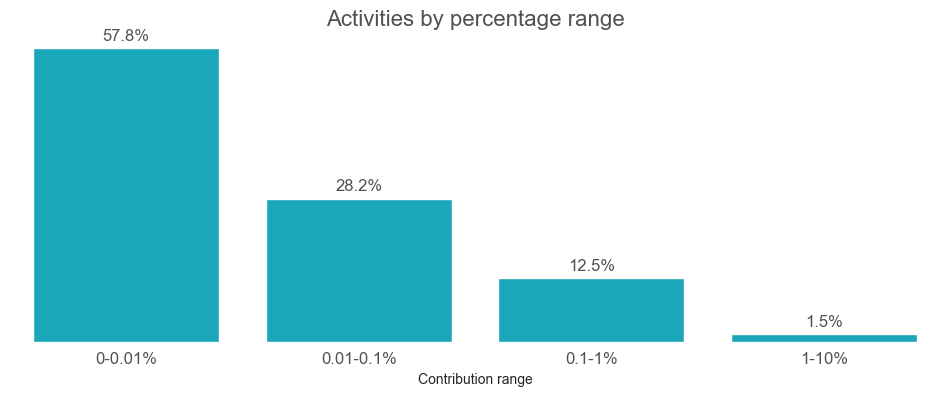

In [811]:


#plotting the distribution of activities by percentage range
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=activites_representative_range, x='percentage_range', y='percentage_activity', color=color2)
plt.title('Activities by percentage range', fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('Contribution range')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)


# Adding the data labels
for i in range(activites_representative_range.shape[0]):
    count = activites_representative_range.iloc[i]['activity'] 
    percentage = activites_representative_range.iloc[i]['percentage_activity']
    plt.text(i, percentage + 1, f'{percentage}%', ha = 'center', va = 'bottom', fontsize=12, alpha=0.8)

plt.show()



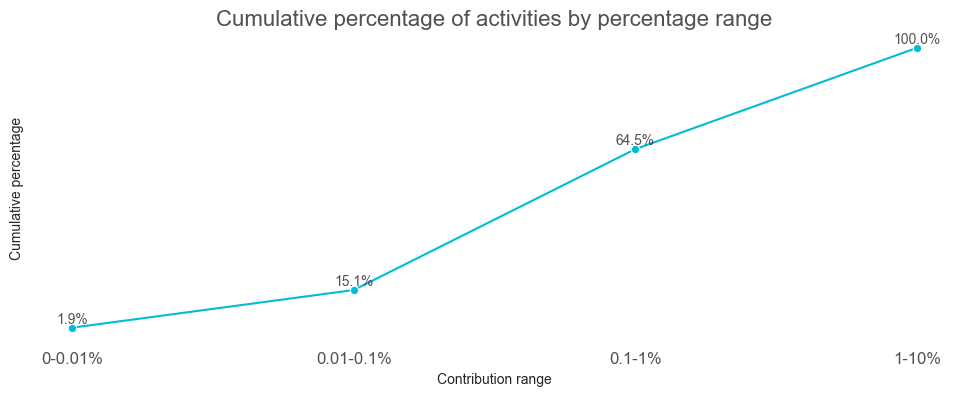

In [812]:
#plot cumulative sum of activities by percentage range
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.lineplot(data=activites_representative_range, x='percentage_range', y='cumulative_percentage', marker='o', color=color2)
plt.title('Cumulative percentage of activities by percentage range', fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('Cumulative percentage')
plt.xlabel('Contribution range')
plt.yticks([])

# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)


#adding data labels
for index, row in activites_representative_range.iterrows():
    plt.text(row.name, row.cumulative_percentage + 0.5, f'{row.cumulative_percentage}%', ha = 'center', va = 'bottom', fontsize=10, alpha=0.8)
plt.show()


In [779]:
# Question 5
# What is the declared capital of those companies?

In [632]:
#Fisrt, create a view to store the active companies list
conn.execute("""DROP VIEW IF EXISTS active_companies;
                CREATE VIEW active_companies AS
                SELECT cnpj_base FROM estabelecimentos WHERE identifier = 1 AND registration_status = 2;""")

In [678]:
# CÓDIGO DO PORTE DA EMPRESA: 00 – NÃO INFORMADO
# 01 - MICRO EMPRESA
# 03 - EMPRESA DE PEQUENO PORTE 05 - DEMAIS
conn.execute("""
         DROP VIEW IF EXISTS active_companies_capital;
         CREATE VIEW active_companies_capital AS 
         SELECT 
            a.cnpj_base,
            c.description AS legal_nature_description,
            cast(replace(replace(a.capital, 'R$',''),',','.') as float) AS social_capital,
            CASE WHEN company_size = '00' THEN 'NOT INFORMED'
                   WHEN company_size = '01' THEN 'MICRO'
                   WHEN company_size = '03' THEN 'SMALL'
                   ELSE 'OTHER'
               END AS company_size
         FROM empresas a
         INNER JOIN estabelecimentos b ON a.cnpj_base = b.cnpj_base
         LEFT JOIN natureza c ON a.legal_nature = c.code
         WHERE b.identifier = 1 AND b.registration_status = 2
             """)

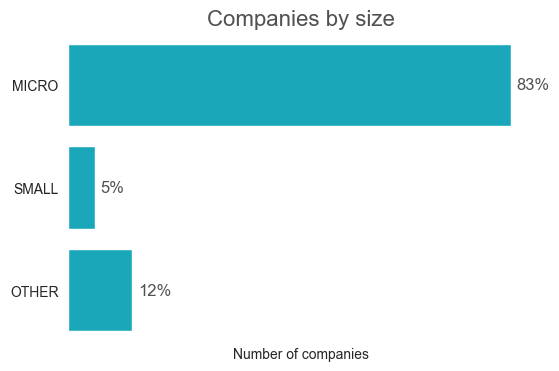

In [711]:
companies_by_size = conn.execute("""SELECT company_size, count(*) number_of_companies, round(avg(social_capital)/1000,1) avg_social_captal_k, round(count(*)/sum(count(*)) over(),2) percentage_of_companies
                FROM active_companies_capital
                GROUP BY 1
                ORDER BY 3 ASC;""").df()
                
plt.figure(figsize=(6, 4))
sns.set_style("white")
sns.barplot(data=companies_by_size, y='company_size', x='percentage_of_companies', color=color2)

plt.title('Companies by size', fontsize=16, alpha=0.8)
# removing y-axis labels and text

plt.ylabel('')
plt.xlabel('Number of companies')
plt.xticks([])
plt.box()
# adding labels

for i in range(companies_by_size.shape[0]):
    count = companies_by_size.iloc[i]['percentage_of_companies']
    percentage = companies_by_size.iloc[i]['percentage_of_companies']
    plt.text(count + 0.01, i, f'{round(100*percentage)}%', ha = 'left', va = 'center', fontsize=12, alpha=0.8)


In [739]:
companies_by_size_capital_categorized = conn.execute("""
SELECT company_size, CASE WHEN social_capital = 0 THEN '0'
                          WHEN social_capital <= 1000 THEN '0-1K'
                          WHEN social_capital <= 10000 THEN '1-10K'
                          WHEN social_capital <= 100000 THEN '10-100K'
                          WHEN social_capital <= 1000000 THEN '100-1M'
                          ELSE '1M+' END AS social_capital_range,
count(*) number_of_companies, 
round(avg(social_capital)/1000,1) avg_social_captal_k, 
round(100 * count(*)/sum(count(*)) over(),1) percentage_of_companies
                FROM active_companies_capital
                GROUP BY 1,2
                ORDER BY 4 ASC;""").df()

#plot heatmap of companies by size and capital range    



In [740]:
companies_by_size_capital_categorized

,company_size,social_capital_range,number_of_companies,avg_social_captal_k,percentage_of_companies
0,OTHER,0,1794974,0.0,8.0
1,SMALL,0,53253,0.0,0.2
2,MICRO,0,610597,0.0,2.7
3,MICRO,0-1K,5268237,0.6,23.6
4,OTHER,0-1K,87370,0.9,0.4
5,SMALL,0-1K,43002,1.0,0.2
6,MICRO,1-10K,7657943,5.6,34.3
7,OTHER,1-10K,219998,7.4,1.0
8,SMALL,1-10K,202452,7.6,0.9
9,MICRO,10-100K,4173023,43.2,18.7


In [791]:
#add custom order to index of companies_by_size_capital_categorized_pivot 


social_capital_range,0,0-1K,1-10K,10-100K,100-1M,1M+
company_size,,,,,,
MICRO,2.7,23.6,34.3,18.7,3.1,0.2
OTHER,8.0,0.4,1.0,1.1,1.0,0.9
SMALL,0.2,0.2,0.9,2.3,1.2,0.1


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'MICRO'), Text(0, 1.5, 'SMALL'), Text(0, 2.5, 'OTHER')])

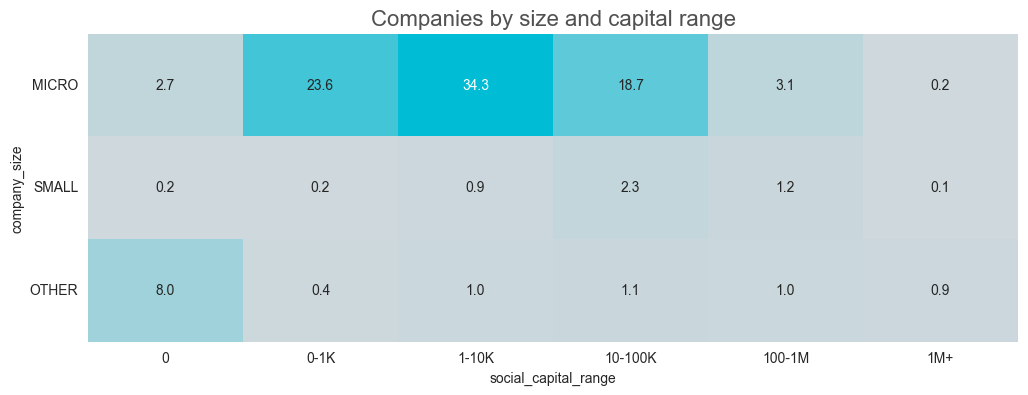

In [805]:

companies_by_size_capital_categorized_pivot = companies_by_size_capital_categorized.sort_values(by='avg_social_captal_k').pivot(index='company_size', columns='social_capital_range', values='percentage_of_companies')

# Micro -> 1.Micro Small-> 2.Small 3.Other

companies_by_size_capital_categorized_pivot = companies_by_size_capital_categorized_pivot.reindex(['MICRO', 'SMALL', 'OTHER'])

plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.heatmap(companies_by_size_capital_categorized_pivot, cmap=custom_palette, annot=True, fmt=".1f", cbar=False)
plt.title('Companies by size and capital range', fontsize=16, alpha=0.8)
#rotate y axis labels
plt.yticks(rotation=0)



In [898]:
legal_nature = conn.execute("""
SELECT legal_nature_description, 
count(*) number_of_companies, 
round(avg(social_capital)/1000,1) avg_social_captal_k, 
round(100 * count(*)/sum(count(*)) over(),1) percentage_of_companies
                FROM active_companies_capital
                GROUP BY 1
                ORDER BY 4 DESC;""").df()

legal_nature = conn.execute(""" SELECT *, rank() over(order by percentage_of_companies desc) as rank
                                FROM legal_nature;""").df()

legal_nature = conn.execute(""" SELECT CASE WHEN rank < 3 THEN legal_nature_description ELSE 'Others' END AS legal_nature_
                                , avg(avg_social_captal_k) avg_social_captal_k
                                , sum(percentage_of_companies) percentage_of_companies
                                FROM legal_nature
                                GROUP BY 1
                                ORDER BY 3 DESC;""").df()
                            
legal_nature

,legal_nature_,avg_social_captal_k,percentage_of_companies
0,Empresário (Individual),150.900000,63.2
1,Sociedade Empresária Limitada,2206.800000,26.9
2,Others,43611.687059,9.7


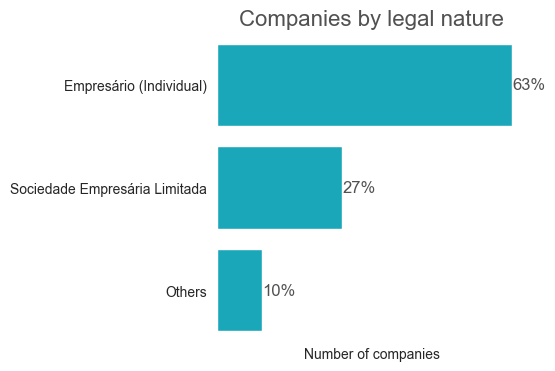

In [858]:
# plot with horizontal bar plot 

plt.figure(figsize=(4, 4))
sns.set_style("white")
sns.barplot(data=legal_nature, y='legal_nature_', x='percentage_of_companies', color=color2)
plt.title('Companies by legal nature', fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('Number of companies')
plt.xticks([])
plt.box()

#add data labels
for i in range(legal_nature.shape[0]):
    count = legal_nature.iloc[i]['percentage_of_companies']
    percentage = legal_nature.iloc[i]['percentage_of_companies']
    plt.text(count + 0.1, i, f'{round(percentage)}%', ha = 'left', va = 'center', fontsize=12, alpha=0.8)



In [934]:
simples_by_legal_nature = conn.execute(""" 
WITH cte As(
SELECT a.cnpj_base, company_size, simples_option, mei_option, legal_nature_description, CASE WHEN legal_nature_ IS NOT NULL THEN legal_nature_ ELSE 'Others' END AS legal_nature_grouped
FROM active_companies_capital a
INNER JOIN simple s on s.cnpj_base =  a.cnpj_base
LEFT JOIN legal_nature l ON l.legal_nature_ = a.legal_nature_description)

SELECT legal_nature_grouped, 
AVG(CASE WHEN simples_option = 'S' THEN 1 ELSE 0 END) is_simples,
AVG(CASE WHEN mei_option = 'S' THEN 1 ELSE 0 END) is_mei,
COUNT(*) n_companies
FROM cte
GROUP BY 1
ORDER BY 3 DESC
""").df()

In [935]:
simples_by_legal_nature

,legal_nature_grouped,is_simples,is_mei,n_companies
0,Empresário (Individual),0.935724,0.822302,13917726
1,Sociedade Empresária Limitada,0.779560,0.000006,4726221
2,Others,0.848810,0.000000,252523


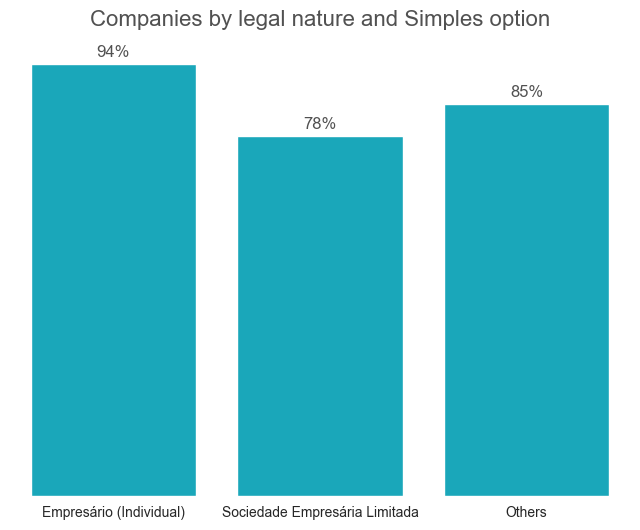

In [936]:
# create  vetical bar plot with 2 bars, for is_simples ans is_mei for each legal_nature grouped

plt.figure(figsize=(8, 6))
sns.set_style("white")
sns.barplot(data=simples_by_legal_nature,  y='is_simples', x='legal_nature_grouped',color=color2)
plt.title('Companies by legal nature and Simples option', fontsize=16, alpha=0.8)
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.box()
plt.ylim(0, 1)

#adding data labels
for i in range(simples_by_legal_nature.shape[0]):
    count = simples_by_legal_nature.iloc[i]['is_simples']
    plt.text(i, count + 0.01, f'{round(count*100)}%', ha = 'center', va = 'bottom', fontsize=12, alpha=0.8)


